# 1. 实验准备阶段 认识数据

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import folium
from datetime import datetime
import pyproj
from sklearn.datasets import make_blobs
from matplotlib import pyplot
import numpy as np
import random
from math import radians, cos, sin, asin, sqrt

In [48]:
 data_2018 = pd.read_csv(r'./data/metro-bike-share-trips-2018-q1.csv')

Q=[2,3]
for q in Q:
    df = pd.read_csv(r'./data/metro-bike-share-trips-2018-q'+str(q)+'.csv')
    data_2018 = pd.concat([data_2018,df],axis=0,ignore_index=True)

### f1:将站点经纬度数据进行整理归总

In [49]:
def cal_station(data):
    """
    输入：原始数据df
    输出：归总后的站点信息
    """
    station_id_list = list(data['start_station'].values)
    station_id_list.extend(list(data['end_station'].values))
    lat_list = list(data['start_lat'].values)
    lat_list.extend(list(data['end_lat'].values))
    lon_list = list(data['start_lon'].values)
    lon_list.extend(list(data['end_lon'].values))
    station_dict = {'station_id':station_id_list,'lat':lat_list,'lon':lon_list}
    station_df = pd.DataFrame(station_dict)
    station_df = station_df.drop_duplicates(subset=['station_id'],keep='first').reset_index(drop=True)
    station_df.to_csv('./data/station_info.csv')
    return station_df

### f2:根据站点信息汇总，输入两站点编号得出两站点间距离

In [50]:
def haversine(station_df,id1,id2):
    """
    通过haversine公式计算两经纬度之间的距离
    输入：
    储存经纬度信息的df，两个站点的id
    输出：
    距离，单位（千米）
    """
    lon1 = station_df[station_df['station_id']==id1]['lon']
    lat1 = station_df[station_df['station_id']==id1]['lat']
    lon2 = station_df[station_df['station_id']==id2]['lon']
    lat2 = station_df[station_df['station_id']==id2]['lat']
    
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    a = sin((lat2 - lat1)/2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) /2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为千米
    return c * r  # 输出单位为千米

### f3:可视化站点分布

In [51]:
def see_station(station_info,mapping,col):
    """
    输入：站点信息
    输出：可视化站点分布
    """
    for i in range(station_info.shape[0]):  
        folium.Marker([station_info.iloc[i]['lat'],station_info.iloc[i]['lon']],
                      popup=(str(station_info.iloc[i]['station_id'])), # 点击出现id
                      icon=folium.Icon(color=str(col))).add_to(mapping)
    return mapping

### 函数调用效果

In [52]:
station_df=cal_station(data_2018)
station_df.head(5)

,station_id,lat,lon
0,3063,34.049198,-118.252831
1,3018,34.043732,-118.260139
2,4204,33.988419,-118.451630
3,4147,34.145248,-118.150070
4,3006,34.045540,-118.256668


In [53]:
haversine(station_df,4133,3005)

35.0691037121536

In [3]:
import folium

folium.Map(
    location=[42.375,117.375],
    tiles='Stamen Toner',
    zoom_start= 6
)

# mapping = folium.Map(location=[42.375,117.375])
# mapping

# 2. 预处理：剔除异常值

In [72]:
"""
取出异常值的index 并删除异常
"""
# 异常1：短时间内在同一站点借还
abnormal_1=data_2018[(data_2018['duration']==1)&(data_2018['start_station']==data_2018['end_station'])].index
# 异常2：借还站点不明确
abnormal_2=data_2018[(data_2018['end_station']==3000)|(data_2018['start_station']==3000)].index
# 两种异常状态取交集
abnormal=list(set(abnormal_1).union(set(abnormal_2)))
print(len(abnormal))
data_2018_cln=data_2018.drop(index = abnormal,axis=1).reset_index(drop=True)

7333


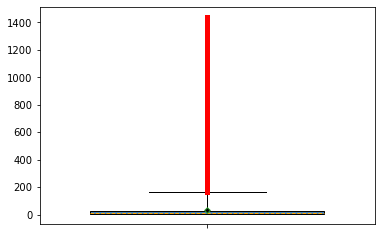

In [56]:
# 绘制箱型图观察骑行时间的异常状态
plt.boxplot(x = data_2018_cln['duration'],         
            whis = 6,       
            widths = 0.7,  
            patch_artist = True,  
            showmeans = True,  
            boxprops = {'facecolor':'steelblue'},    
            flierprops = {'markerfacecolor':'red', 'markeredgecolor':'red', 'markersize':4},          
            meanprops = {'marker':'D','markerfacecolor':'black', 'markersize':4},          
            medianprops = {'linestyle':'--','color':'orange'},        
            labels = ['']) 
plt.show()

In [66]:
# 依据6倍的四分位差判断异常
Q1 = data_2018_cln['duration'].quantile(q = 0.25)
Q3 = data_2018_cln['duration'].quantile(q = 0.75)
low_whisker = Q1 - 6*(Q3 - Q1)# 寻找异常点上限
up_whisker = Q3 + 6*(Q3 - Q1)# 寻找异常点下限
data_2018_cln=data_2018_cln[(data_2018_cln['duration']>=low_whisker)&(data_2018_cln['duration']<=up_whisker)]

## 2.预处理:依据地理位置以及站点间的相互转换关系进行KMediod聚类，并得出各类在不同时刻下的需求量

使用KMediod的原因在于他是在点上做聚类，而不是平均距离，这样便于将两点间的距离换成相似度矩阵中的数值

In [67]:
"""
将str转为datetime，精度只保留到小时的单位
"""
if type(data_2018_cln['start_time'][0])==str:
    data_2018_cln['start_time']=data_2018_cln['start_time'].apply(lambda x:datetime.strptime(x[:-6],'%Y-%m-%d %H'))
    data_2018_cln['end_time']=data_2018_cln['end_time'].apply(lambda x:datetime.strptime(x[:-6],'%Y-%m-%d %H'))

In [68]:
"""
创建站点和时间的对应矩阵
"""
date_list=[]
for m in range(1,13):
    if(m==1)|(m==3)|(m==5)|(m==7)|(m==8):
        for d in range(1,32):
            for h in range(0,24):
                temp_date = datetime.strptime('2018-'+str(m)+'-'+str(d)+'-'+str(h),'%Y-%m-%d-%H')
                date_list.append(temp_date)
    elif(m==4)|(m==6)|(m==9):
        for d in range(1,31):
            for h in range(0,24):
                temp_date = datetime.strptime('2018-'+str(m)+'-'+str(d)+'-'+str(h),'%Y-%m-%d-%H')
                date_list.append(temp_date)
        
    elif m==2:
        for d in range(1,29):
            for h in range(0,24):
                temp_date = datetime.strptime('2018-'+str(m)+'-'+str(d)+'-'+str(h),'%Y-%m-%d-%H')
                date_list.append(temp_date)
                

station_df=cal_station(data_2018_cln)
value_count = [[0]*(station_df.shape[0])]*(len(date_list))

out_dict=dict(zip(date_list,value_count))
out_df = pd.DataFrame(out_dict)
out_df['station_id']=station_df['station_id'].astype(int)
out_df.set_index(['station_id'],inplace=True)
out_df.sort_index(ascending=True,inplace=True)
out_df.head(5)

,2018-01-01 00:00:00,2018-01-01 01:00:00,2018-01-01 02:00:00,2018-01-01 03:00:00,2018-01-01 04:00:00,2018-01-01 05:00:00,2018-01-01 06:00:00,2018-01-01 07:00:00,2018-01-01 08:00:00,2018-01-01 09:00:00,...,2018-09-30 14:00:00,2018-09-30 15:00:00,2018-09-30 16:00:00,2018-09-30 17:00:00,2018-09-30 18:00:00,2018-09-30 19:00:00,2018-09-30 20:00:00,2018-09-30 21:00:00,2018-09-30 22:00:00,2018-09-30 23:00:00
station_id,,,,,,,,,,,,,,,,,,,,,
3005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
"""
统计各个站点在每个时间的需求量
"""
# for i in range(data_2018_cln.shape[0]):
#     index=data_2018_cln.loc[i]['start_station']
#     time=data_2018_cln.loc[i]['start_time'].strftime('%Y-%m-%d %H:%M:%S')
#     out_df.loc[index][time]=out_df.loc[index][time]+1

# out_df.to_csv('./data/out_2018.csv')
out_df=pd.read_csv('./data/out_2018.csv')
out_df.head(5)

,station_id,2018-01-01 00:00:00,2018-01-01 01:00:00,2018-01-01 02:00:00,2018-01-01 03:00:00,2018-01-01 04:00:00,2018-01-01 05:00:00,2018-01-01 06:00:00,2018-01-01 07:00:00,2018-01-01 08:00:00,...,2018-09-30 14:00:00,2018-09-30 15:00:00,2018-09-30 16:00:00,2018-09-30 17:00:00,2018-09-30 18:00:00,2018-09-30 19:00:00,2018-09-30 20:00:00,2018-09-30 21:00:00,2018-09-30 22:00:00,2018-09-30 23:00:00
0,3005,0,0,1,0,0,1,0,0,0,...,11,2,4,1,4,2,2,1,0,0
1,3006,2,0,0,0,0,0,0,0,0,...,0,1,3,2,4,2,0,1,0,0
2,3007,0,1,0,0,0,0,0,0,0,...,1,4,1,2,0,0,0,0,0,0
3,3008,0,0,0,0,0,0,0,0,0,...,2,0,4,1,0,2,1,0,0,1
4,3010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [75]:
"""
计算相似度矩阵，a代表站点交互关系的权重，矩阵中的值越大，表示相似度越弱，距离越远
站点间的距离和交互关系都进行了无量纲化处理
"""

# 计算每个站点总的出借量
station_df=cal_station(data_2018_cln)
time_based_out = pd.DataFrame(out_df.values.T, index=out_df.columns, columns=out_df.index)#转置
year_count=np.array([time_based_out[column].sum() for column in list(time_based_out.columns)]) # 依据行标题进行求和
station_id=np.array(time_based_out.columns)
station_df['year_count']=year_count

# 制作相似度矩阵
station_df=station_df.sort_values(by='station_id').reset_index(drop=True)
similarity = [[0]*(station_df.shape[0])]*(station_df.shape[0])
similarity_dict=dict(zip(station_df['station_id'],similarity))
similarity_df = pd.DataFrame(similarity_dict)
similarity_df['station_id']=station_df['station_id']
similarity_df.set_index(['station_id'],inplace=True)

# 依据距离和转换关系形成相似度矩阵
for item in range(data_2018_cln.shape[0]):
    i=data_2018_cln.loc[item]['start_station']
    j=data_2018_cln.loc[item]['end_station']
    similarity_df.loc[i][j]=similarity_df.loc[i][j]+1

a=0.5
for i in range(similarity_df.shape[0]):
    similarity_df.iloc[i]= (1-a*(similarity_df.iloc[i]/station_df.iloc[i]['year_count']))
    
for i in range(similarity_df.shape[0]):
    for j in range(i,similarity_df.shape[0]):
        similarity_df.iloc[i,j]=similarity_df.iloc[i,j]*(0.01*haversine(station_df,int(station_df.iloc[i]['station_id']),int(station_df.iloc[j]['station_id'])))
        similarity_df.iloc[j,i]=similarity_df.iloc[j,i]*(0.01*haversine(station_df,int(station_df.iloc[i]['station_id']),int(station_df.iloc[j]['station_id'])))   

# similarity_df = pd.read_csv('./data/bike/similarity_station.csv') # 站点相似性矩阵
# similarity_df.set_index(['station_id'], inplace=True)
# similarity_df.head(5)

,3005,3006,3007,3008,3010,3011,3013,3014,3016,3018,...,4220,4227,4244,4245,4246,4248,4249,4250,4254,4267
station_id,,,,,,,,,,,,,,,,,,,,,
3005,0.000000,0.003574,0.004178,0.004290,0.013066,0.011763,0.298788,0.021365,0.016367,0.005352,...,0.029055,0.023422,0.042644,0.035480,0.033395,0.035623,0.037593,0.028942,0.032228,0.030905
3006,0.003635,0.000000,0.005770,0.005679,0.009577,0.011458,0.295526,0.021699,0.016130,0.003758,...,0.032537,0.021522,0.041244,0.034330,0.031916,0.035137,0.036013,0.028149,0.031458,0.029776
3007,0.004137,0.005743,0.000000,0.008529,0.014919,0.015984,0.301062,0.017309,0.012285,0.008758,...,0.027253,0.027167,0.046640,0.039610,0.037387,0.039883,0.041508,0.033160,0.036423,0.034985
3008,0.004324,0.005664,0.008578,0.000000,0.012857,0.007583,0.296660,0.025706,0.020713,0.003987,...,0.031535,0.019951,0.038690,0.031502,0.029595,0.031309,0.033795,0.024766,0.028007,0.026818
3010,0.013130,0.009576,0.014932,0.012860,0.000000,0.012899,0.286125,0.027121,0.021465,0.008873,...,0.042161,0.016349,0.036165,0.030016,0.026859,0.032618,0.030570,0.025216,0.028509,0.025993


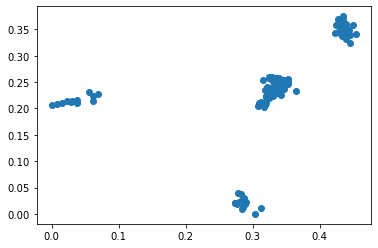

In [44]:
Descartes_df=station_df.copy()
corr_lat=Descartes_df['lat'].min()
corr_lon=Descartes_df['lon'].min()
Descartes_df['lat']=Descartes_df['lat']-corr_lat
Descartes_df['lon']=Descartes_df['lon']-corr_lon

plt.scatter(Descartes_df['lat'],Descartes_df['lon'])
plt.show()

In [45]:
class KMediod():
    """
    KMediod聚类 用相似度矩阵替换欧氏距离计算
    输入：
    记录站点信息的表格
    记录站点间相似度的表格
    聚类个数
    输出：
    各个站点所属的类别
    """
    
    def __init__(self, data, similarity_df, k):
        self.org_data=data
        x0=list(data['lat'].values)
        x1=list(data['lon'].values)
        self.data = np.array([list(D) for D in(zip(x0,x1))])
        self.similarity = similarity_df
        self.k = k
 
    def cal_distance(self, x, y):
        # 利用相似度矩阵代替欧式距离的计算
        i = self.org_data[(self.org_data['lat']==x[0])&(self.org_data['lon']==x[1])].index
        j = self.org_data[(self.org_data['lat']==y[0])&(self.org_data['lon']==y[1])].index
        return self.similarity.iloc[i,j].values
 
    def run_k_center(self, cal_distance):
        print('初始化', self.k, '个中心点')
        indexs = list(range(len(self.data)))
        # 为保证聚类的稳定性及准确性，人为设定初始化中心点
        init_centroids_index = self.org_data[(self.org_data['station_id']==4154)|(self.org_data['station_id']==4144)|
                                        (self.org_data['station_id']==4216)|(self.org_data['station_id']==4204)|
                                        (self.org_data['station_id']==4133)|(self.org_data['station_id']==3064)|
                                        (self.org_data['station_id']==3066)|(self.org_data['station_id']==4245)|
                                        (self.org_data['station_id']==3056)|(self.org_data['station_id']==3054)|
                                        (self.org_data['station_id']==3038)].index
        centroids = self.data[init_centroids_index, :]   # 初始中心点
        # 确定种类编号
        levels = list(range(self.k))
        sample_target = []
        if_stop = False
        while(not if_stop):
            if_stop = True
            classify_points = [[centroid] for centroid in centroids]
            sample_target = []
            # 遍历数据
            for sample in self.data:
                # 计算距离，由距离该数据最近的核心，确定该点所属类别
                distances = [cal_distance(sample, centroid) for centroid in centroids]
                cur_level = np.argmin(distances)
                sample_target.append(cur_level)
                # 统计，方便迭代完成后重新计算中间点
                classify_points[cur_level].append(sample)
            # 重新划分质心
            for i in range(self.k):  # 几类中分别寻找一个最优点
                distances = [cal_distance(point_1, centroids[i]) for point_1 in classify_points[i]]
                #  计算出现在中心点和其他所有点的距离总和
                now_distances = sum(distances)   
                for point in classify_points[i]:
                    distances = [cal_distance(point_1, point) for point_1 in classify_points[i]]
                    new_distance = sum(distances)
                    # 计算出该聚簇中各个点与其他所有点的总和，若是有小于当前中心点的距离总和的，中心点去掉
                    if new_distance < now_distances:
                        now_distances = new_distance
                        centroids[i] = point    # 换成该点
                        if_stop = False
        return sample_target
        

In [46]:
"""
进行聚类以及可视化
"""
test_one = KMediod(Descartes_df,similarity_df,k=11)
seprate=test_one.run_k_center(test_one.cal_distance)
station_df['sept']=seprate

mapping = folium.Map(location=[34.049198,-118.252831]) # 将地图中心定位到LA
color_list=['blue','green','lightred','orange','pink','darkpurple','gray','beige','purple','darkred','darkgreen']
for i in range(11):
    mapping=see_station(station_df[station_df['sept']==i],mapping,color_list[i])
mapping

初始化 11 个中心点


In [22]:
sept_out_df = out_df.copy()
sept_out_df['sept']=station_df['sept'].values
sept_out_df=sept_out_df.groupby('sept').sum() # 基于分好的类统计各时段个站点需求量
sept_out_df=sept_out_df.reset_index()
sept_out_df=sept_out_df.drop(columns=['sept','station_id'])
sept_out_df

,2018-01-01 00:00:00,2018-01-01 01:00:00,2018-01-01 02:00:00,2018-01-01 03:00:00,2018-01-01 04:00:00,2018-01-01 05:00:00,2018-01-01 06:00:00,2018-01-01 07:00:00,2018-01-01 08:00:00,2018-01-01 09:00:00,...,2018-09-30 14:00:00,2018-09-30 15:00:00,2018-09-30 16:00:00,2018-09-30 17:00:00,2018-09-30 18:00:00,2018-09-30 19:00:00,2018-09-30 20:00:00,2018-09-30 21:00:00,2018-09-30 22:00:00,2018-09-30 23:00:00
0,2,10,2,0,0,3,1,1,2,2,...,49,31,41,25,28,14,13,3,8,3
1,5,0,4,1,0,0,0,0,0,0,...,8,2,13,15,5,3,1,4,0,4
2,0,0,0,0,0,0,0,0,0,0,...,1,7,2,3,6,7,0,0,1,0
3,9,10,2,0,2,1,2,0,0,3,...,58,45,63,37,18,11,7,7,4,4
4,0,1,1,0,0,0,0,0,2,0,...,2,9,3,6,3,3,3,2,2,3
5,0,0,0,0,0,0,0,0,1,1,...,6,0,0,1,0,0,2,3,0,0
6,1,0,1,0,2,0,3,2,2,0,...,0,0,0,0,0,0,0,0,0,0
7,6,1,0,2,1,3,7,5,11,20,...,0,0,0,0,0,0,0,0,0,0
8,1,0,1,0,0,0,0,2,3,0,...,11,31,17,19,10,13,2,2,2,0
9,0,1,0,0,0,0,0,0,1,0,...,4,4,5,4,0,2,0,1,0,0


In [138]:
time_based_out_sept = pd.DataFrame(sept_out_df.values.T, index=sept_out_df.columns, columns=sept_out_df.index)#转置
time_based_out_sept

,0,1,2,3,4,5,6,7,8,9,10
2018-01-01 00:00:00,2,5,0,9,0,0,1,6,1,0,0
2018-01-01 01:00:00,10,0,0,10,1,0,0,1,0,1,0
2018-01-01 02:00:00,2,4,0,2,1,0,1,0,1,0,0
2018-01-01 03:00:00,0,1,0,0,0,0,0,2,0,0,0
2018-01-01 04:00:00,0,0,0,2,0,0,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,14,3,7,11,3,0,0,0,13,2,3
2018-09-30 20:00:00,13,1,0,7,3,2,0,0,2,0,2
2018-09-30 21:00:00,3,4,0,7,2,3,0,0,2,1,0
2018-09-30 22:00:00,8,0,1,4,2,0,0,0,2,0,2


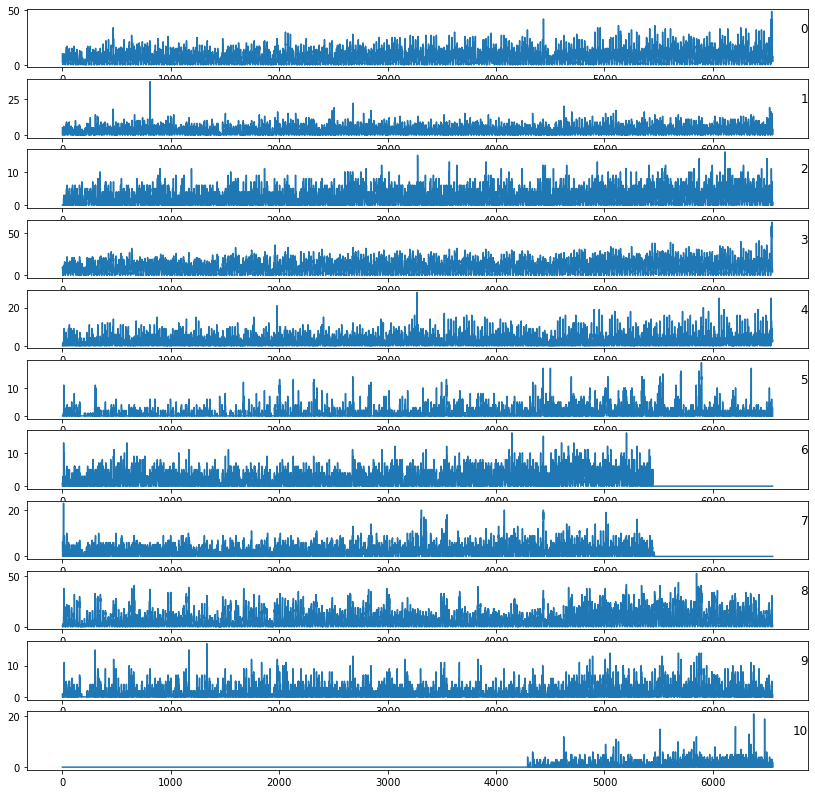

In [141]:
def show_graph(dataset):
    values = dataset.values
    columns = [i for i in range(dataset.shape[1])]
    pyplot.figure(figsize=(14,14))
    i=1
    for column in columns:
        pyplot.subplot(len(columns), 1, i)
        pyplot.plot(values[:, column])
        pyplot.title(column, y=0.5, loc='right')
        i += 1
    pyplot.show()
    
show_graph(time_based_out_sept)

In [143]:
# 由于第6、7两类站点后期出现弃用，做删除处理
time_based_out_sept.drop(columns=[6,7,10],inplace=True)
time_based_out_sept.rename(columns={8:6,9:7},inplace=True)
time_based_out_sept

,0,1,2,3,4,5,6,7
2018-01-01 00:00:00,2,5,0,9,0,0,1,0
2018-01-01 01:00:00,10,0,0,10,1,0,0,1
2018-01-01 02:00:00,2,4,0,2,1,0,1,0
2018-01-01 03:00:00,0,1,0,0,0,0,0,0
2018-01-01 04:00:00,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,14,3,7,11,3,0,13,2
2018-09-30 20:00:00,13,1,0,7,3,2,2,0
2018-09-30 21:00:00,3,4,0,7,2,3,2,1
2018-09-30 22:00:00,8,0,1,4,2,0,2,0


In [144]:
time_based_out_sept.to_csv('./data/bike/time_based_out_sept.csv')
# station_df.to_csv('./data/bike/station_df.csv') # 站点经纬度信息
# similarity_df.to_csv('./data/bike/similarity_station.csv') # 站点相似性矩阵
# out_df.to_csv('./data/bike/out_2018.csv')# 所有站点各个时刻的流出信息
# sept_out_df.to_csv('./data/bike/sept_out.csv') # 聚类后各类的信息
# sept_out_df = pd.read_csv('./data/bike/sept_out.csv')

In [147]:
"""
对每个集群的各个小时分别做平滑处理，剔除在1.5倍4分位距外的点，使用该集群该小时四舍五入的平均数代替
"""
import math
time_based_out_sept_smooth = time_based_out_sept.copy()
for i in range(time_based_out_sept_smooth.shape[1]):
    for t in range(24):
        Q1 = time_based_out_sept_smooth[i][t::24].quantile(q = 0.25)
        Q3 = time_based_out_sept_smooth[i][t::24].quantile(q = 0.75)
        low_whisker = Q1 - 1.5*(Q3 - Q1)# 寻找异常点上限.
        up_whisker = Q3 + 1.5*(Q3 - Q1)# 寻找异常点下限
        time_based_out_sept_smooth[i][t::24] = time_based_out_sept_smooth[i][t::24].apply(lambda x: x if (x<=up_whisker)&(x>=low_whisker) else math.floor(time_based_out_sept_smooth[i][t::24].values.mean()+0.5))

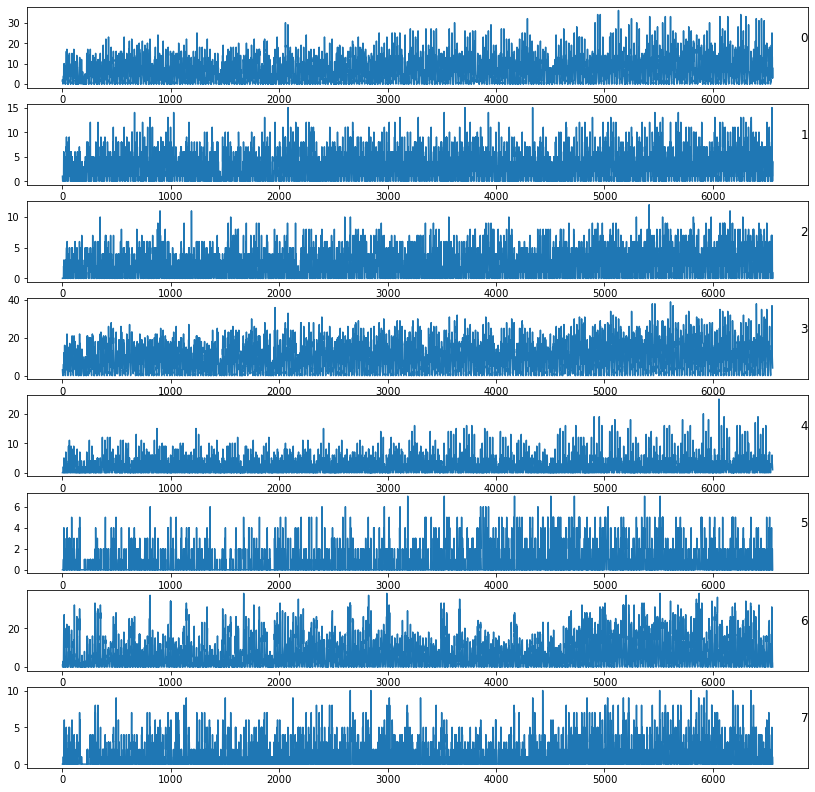

In [148]:
time_based_out_sept_smooth.to_csv('./data/bike/time_based_out_sept_smooth.csv')
show_graph(time_based_out_sept_smooth)

In [150]:
"""
提取日期中的月、日、小时作为特征，并将集群类别也化为特征
"""
time_feture_df = pd.DataFrame([[0]*4]*time_based_out_sept.shape[0], index=time_based_out_sept.index, columns=['month','day','weekday','hour'])#转置
time_feture_df=time_feture_df.reset_index().rename(columns={'index':'datetime'})
time_feture_df['datetime']=time_feture_df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
time_feture_df['month'] =  time_feture_df['datetime'].dt.month
time_feture_df['day'] =  time_feture_df['datetime'].dt.day
time_feture_df['hour'] =  time_feture_df['datetime'].dt.hour
time_feture_df['weekday'] =  time_feture_df['datetime'].dt.weekday+1

time_based_out_sept_smooth_timeinfro = time_based_out_sept_smooth.copy()
time_based_out_sept_smooth_timeinfro['month'] = time_feture_df['month'].values
time_based_out_sept_smooth_timeinfro['day'] = time_feture_df['day'].values
time_based_out_sept_smooth_timeinfro['hour'] = time_feture_df['hour'].values
time_based_out_sept_smooth_timeinfro['weekday'] = time_feture_df['weekday'].values

time_based_out_sept_smooth_timeinfro.to_csv('./data/bike/time_based_out_sept_smooth_timeinfro.csv')
time_based_out_sept_smooth_timeinfro

,0,1,2,3,4,5,6,7,month,day,hour,weekday
2018-01-01 00:00:00,2,1,0,3,0,0,1,0,1,1,0,1
2018-01-01 01:00:00,1,0,0,2,0,0,0,0,1,1,1,1
2018-01-01 02:00:00,2,0,0,2,0,0,0,0,1,1,2,1
2018-01-01 03:00:00,0,0,0,0,0,0,0,0,1,1,3,1
2018-01-01 04:00:00,0,0,0,2,0,0,0,0,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,14,3,7,11,3,0,13,2,9,30,19,7
2018-09-30 20:00:00,13,1,0,7,3,2,2,0,9,30,20,7
2018-09-30 21:00:00,3,4,0,7,2,1,2,1,9,30,21,7
2018-09-30 22:00:00,8,0,1,4,2,0,2,0,9,30,22,7


In [26]:
time_based_out_sept_smooth_timeinfro=pd.read_csv('./data/bike/time_based_out_sept_smooth_timeinfro.csv')

In [27]:
basic_model_df = pd.DataFrame([[0]*6]*52416, columns=['cluster','month','day','weekday','hour','demands'])#转置

In [28]:
import warnings
warnings.filterwarnings("ignore")

for i in range(8):
    basic_model_df['cluster'][i*6552:i*6552+6552] = i
    basic_model_df['month'][i*6552:i*6552+6552] = time_based_out_sept_smooth_timeinfro['month'].values
    basic_model_df['day'][i*6552:i*6552+6552] = time_based_out_sept_smooth_timeinfro['day'].values
    basic_model_df['weekday'][i*6552:i*6552+6552] = time_based_out_sept_smooth_timeinfro['weekday'].values
    basic_model_df['hour'][i*6552:i*6552+6552] = time_based_out_sept_smooth_timeinfro['hour'].values
    basic_model_df['demands'][i*6552:i*6552+6552] = time_based_out_sept_smooth_timeinfro[str(i)].values
    

In [29]:
basic_model_df.to_csv('./data/bike/basic_model_df.csv')
basic_model_df

,cluster,month,day,weekday,hour,demands
0,0,1,1,1,0,2
1,0,1,1,1,1,1
2,0,1,1,1,2,2
3,0,1,1,1,3,0
4,0,1,1,1,4,0
...,...,...,...,...,...,...
52411,7,9,30,7,19,2
52412,7,9,30,7,20,0
52413,7,9,30,7,21,1
52414,7,9,30,7,22,0


In [30]:
basic_model_df=pd.read_csv('./data/bike/basic_model_df.csv')

<BarContainer object of 24 artists>

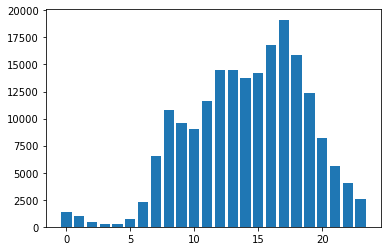

In [31]:
basic_model_hour=basic_model_df.groupby('hour').sum() 
plt.bar(np.array(range(24)),basic_model_hour['demands'].values)

<BarContainer object of 7 artists>

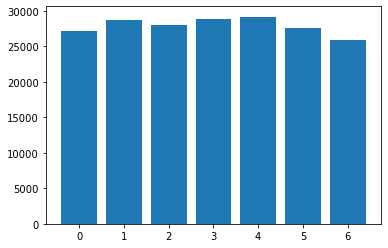

In [32]:
basic_model_weekday=basic_model_df.groupby('weekday').sum() 
plt.bar(np.array(range(7)),basic_model_weekday['demands'].values)

<BarContainer object of 9 artists>

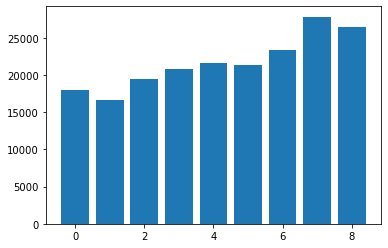

In [34]:
basic_model_month=basic_model_df.groupby('month').sum() 
plt.bar(np.array(range(9)),basic_model_month['demands'].values)